In [1]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import random
import torch.nn.functional as f
from numba import njit

In [2]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(dim, minimum,maximum):
    x = random_shapes((dim, dim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = (-1*x+255)/255
    return(x)

In [3]:
imgDim = 16 #image dimension
mov_length = 8 

In [51]:
#Create array of start images
images_seq = [shape_gen(imgDim,4,10) for i in range(100000)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)

test_seq = [shape_gen(imgDim,4,10) for i in range(1000)]
test_seq = np.array(test_seq)
test_seq = np.expand_dims(test_seq,1)

In [54]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
    def M_gen(i):
        hor = random.randint(-trans_range, trans_range)
        ver = random.randint(-trans_range, trans_range)
        x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
        
        return(x)
    
    Z = np.array([M_gen(i) for i in range(data.shape[0])])
    
    return(Z)
    

In [58]:
M = rand_trans(images_seq, 1, 0, 45)
M2 = rand_trans(test_seq, 1, 0, 45)

In [59]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len,imgDim):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],transform[i],(imgDim,imgDim)) for i in range(data.shape[0])])
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2)
    return(X) #reshape so it's easier to work with

In [70]:
dataNP = image_gen(images_seq, M, mov_length, imgDim)
test_rawNP = image_gen(test_seq, M2, mov_length, imgDim)

data = torch.from_numpy(image_gen(images_seq, M, mov_length, imgDim)).cuda()
data = data.float()

In [62]:
def multi_gen(test_seq, testSize, maxShapes):
    
    #Set up first array, then just loop by concatenating.
    
    test_data = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)] #choose random number of movie sequences
    test_data = np.sum(test_data,axis= 0) #sum them together
    test_data[test_data > 1] = 1 #cap images at 1
    test_data = np.expand_dims(test_data, axis = 0) #add back the extra first axis, which indexes every movie sequence
    
    for datum in range(1,testSize):
        subset = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)]
        subset = np.sum(subset,axis=0)
        subset[subset > 1] = 1
        subset = np.expand_dims(subset, axis = 0)
        test_data = np.concatenate((test_data,subset),axis=0)
    
    return(test_data)

In [63]:
testNP = multi_gen(test_rawNP, 100, 2)
test = torch.from_numpy(testNP)
test = test.float().cuda()

In [64]:
#Rationale: since movies of multiple objects, with overlap, will just be sum of two images with values capped at 255,
#want transforms to reflect this ceiling like behavior or else prediction might be bad. 
#Will use a smooth squashing function, tanh.

def squash(x):
    y = 1.3*torch.tanh(x) #1.3 so will be approxiamtely linear on [-1,1]
    return(y)

def squash_deriv(x):
    y = 1.3*(1-torch.tanh(x)**2)
    return(y)

def squashNP(x):
    y = 1.3*np.tanh(x) #1.3 so will be approxiamtely linear on [-1,1]
    return(y)

def squash_derivNP(x):
    y = 1.3*(1-np.tanh(x)**2)
    return(y)

In [82]:
numTransforms = 16
trainSteps = 1000
batchSize = 25 #training 
sparsePen = 12
derivPen = 12
epsilon = 1 #variance of normal desntiy in the smoothed bump function.
eta = .02 #learning rate of phi, the dictionary of transforms
eta2 = .02 #learning rate of beta, the transform coeff
eta3 = 1000 #Learning rate of center
eta4 = 1000 #Learning rate of radii
numInference = 150 #arbitrary
numInf2 = 40
betaStep = 20 #FOR TRAINED TRANSFORMS. mini cycle for beta
attStep = 20 #FOR TRAINED TRANSFORMS. mini cycle for center/radii

In [67]:
#Training algorithm, image sequences with one shape. No need to infer center/radii yet.
def timeDeriv(beta):
    #assuming beta has shape btk, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = torch.zeros((beta.size()[0],1,beta.size()[2])).cuda()
    timeDiff = beta[:,1:,:] - beta[:,:(beta.size(1)-1),:]
    tmDiffnorm = torch.norm(timeDiff, p=1, dim=1)
    deriv_part1 = (tmDiffnorm/(tmDiffnorm**2+1)).unsqueeze(1) #normalize across time
    X = torch.cat((Zeroes, timeDiff), 1)
    Y = torch.cat((timeDiff,Zeroes), 1)
    Z = torch.sign(X) - torch.sign(Y)
    timeBeta = deriv_part1*Z
    
    return(timeBeta)

def timeDerivNP(beta):
    #assuming beta has shape btk, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = np.zeros((beta.shape[0],1,beta.shape[2]))
    timeDiff = np.diff(beta, axis= 1)
    tmDiffnorm = np.linalg.norm(timeDiff, ord = 1, axis=1)#normalize across time
    deriv_part1 = tmDiffnorm/(tmDiffnorm**2+1) 
    deriv_part1 = np.expand_dims(deriv_part1, axis = 1)
    X = np.concatenate((Zeroes, timeDiff), axis=1)
    Y = np.concatenate((timeDiff,Zeroes), axis =1)
    Z = np.sign(X)-np.sign(Y)
    timeBeta = np.multiply(deriv_part1,Z)
    
    return(timeBeta)


def sparseDeriv(beta):
    #assume beta has shape btk.
    
    norm_beta = np.linalg.norm(beta, ord = 1, axis=2) #normalize btk, for all batches and time
    deriv_part1 = norm_beta/(norm_beta**2+1)
    deriv_part1 = deriv_part1.unsqueeze(2)
    sparseBeta = deriv_part1*torch.sign(beta)
    
    return(sparseBeta)

def sparseDerivNP(beta):
    #assume beta has shape btk.
    
    norm_beta = np.linalg.norm(beta,ord=1, axis=2) #normalize btk, for all batches and time
    deriv_part1 = norm_beta/(norm_beta**2+1)
    deriv_part1 = np.expand_dims(deriv_part1, axis = 2)
    sparseBeta = np.multiply(deriv_part1,np.sign(beta))
    
    return(sparseBeta)

def inferBeta(Input, Output, phi, sparsePen, derivPen, eta2):
    #Assume data has shape (B, T, n2), where number of images(usually batch size) , T is time, and n2 is n^2 for nxn image
    #phi is of shape (i,i',k) where i,i' denote image dim, k denotes transform, T is time, and B is batch
    #Input are first T-1 frames. Output are frames 2 to T. Infer i^th frame from previous.
    
    beta = torch.rand((Input.size()[0],Input.size()[1],phi.size()[2])).cuda() #initialize beta at 0. beta is shape btk
    
    for step in range(numInference):
        predictions = torch.einsum('btk,ijk,btj -> bti', beta, phi, Input)
        dTanh = squash_deriv(predictions)
        error = Output - squash(predictions)
        dBeta = torch.einsum('bti,ijk,btj, btj -> btk', error, phi, dTanh, Input) - sparsePen*sparseDeriv(beta) - derivPen*timeDeriv(beta)
        beta += eta2*dBeta
        
    return(beta)

    
def learnTransform(Input, Output, phi, beta, eta, batchSize):
    
    predictions = torch.einsum('btk,ijk,btj -> bti', beta, phi, Input)
    error = Output - squash(predictions)
    dTanh = squash_deriv(predictions)
    dPhi = torch.einsum('bti, btj, btj, btk -> ijk', error, dTanh, Input, beta)
    phi += (eta/batchSize)*dPhi
    
    return(phi, error)
    

#Traning algo, image sequences with one shape.

def TrainMore(dataset, phi, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.size()[2]
    
    #ax = plt.subplot(1,1,1)
    #start training
    for trial in range(trainSteps):
        
        data_batch = dataset[np.random.randint(0,dataset.size()[0],batchSize)] #create random batch
        Input = data_batch[:,:(dataset.size()[1]-1),:] #will predict next frame from these
        Output = data_batch[:,1:,:] #the frames to be predicted

        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
        phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

        #renormalize by making transforms have norm 1.
        #phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
        phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)


        if trial%10 == 0: #print every 10 steps
            normError = torch.norm(error).item()
            print('trial: %s ; NormedLoss: %s' % (trial,normError))
        else:
            print('trial: %s' % trial, end='\r')
#             normError = torch.norm(error).item()
#             print('trial: %s ; NormedLoss: %s' % (trial,normError))
#     plt.show()
    return(phi)
    

In [38]:
#Use this to check what SparsePen/derivPen should be. For 16x16, 1/60 and 1/90 for Sparse/Deriv respectively seems
#to be a good starting point relative to total batch-wide normedError. Maybe want a little higher

data_batch = data[np.random.randint(0,data.size()[0],batchSize)] #create random batch
Input = data_batch[:,:(data.size()[1]-1),:] #will predict next frame from these
Output = data_batch[:,1:,:] #the frames to be predicted


dim = data.size()[2]
phi = torch.rand(dim, dim ,numTransforms).cuda()+.0001 #n2 x n2 x 15. added small number to prevent dividing by zero.


#Find beta, fix, then optimize phi
beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

#renormalize by making transforms have norm 1.
#phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)

timeDiff = beta[:,1:,:] - beta[:,:(beta.size(1)-1),:]
tmDiffnorm = torch.norm(timeDiff,dim=1)

print('sparse: %s  time: %s  error: %s' % (torch.log(torch.norm(beta)**4 + 1),torch.log(torch.norm(timeDiff)**4 + 1),torch.norm(error)))

sparse: tensor(30.3649)  time: tensor(31.3601)  error: tensor(270.7589)


In [393]:
#Traning algo, image sequences with one shape.

def Training1(dataset, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.size()[2]
    phi = torch.rand(dim, dim ,numTransforms).cuda()+.0001 #n2 x n2 x 15. added small number to prevent dividing by zero.
    
    #ax = plt.subplot(1,1,1)
    #start training
    eta_phase2 = eta*.5
#     sparsePen_phase2 = sparsePen*.8
#     derivPen_phase2 = derivPen*.8
    for trial in range(trainSteps): #iteratively relax learning rate
        if trial <= trainSteps/3:
            pass
        else:
            eta= eta_phase2
#             sparsePen = sparsePen_phase2
#             derivPen = derivPen_phase2
#above code also in case want to intitally force algo to choose sparse, time-consistent soltuions to get good "initializations"
        
        data_batch = dataset[np.random.randint(0,dataset.size()[0],batchSize)] #create random batch
        Input = data_batch[:,:(dataset.size()[1]-1),:] #will predict next frame from these
        Output = data_batch[:,1:,:] #the frames to be predicted

        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
        phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

        #renormalize by making transforms have norm 1.
        #phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
        phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)


        if trial%10 == 0: #print every 10 steps
            normError = torch.norm(error).item()
            print('trial: %s ; NormedLoss: %s' % (trial,normError))
        else:
            print('trial: %s' % trial, end='\r')
#         normError = torch.norm(error).item()
#         print('trial: %s ; NormedLoss: %s' % (trial,normError))
#     plt.show()
    return(phi)
    

In [452]:
learnedPhi8 = Training1(data, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms)

trial: 0 ; NormedLoss: 274.4008483886719
trial: 10 ; NormedLoss: 50.93622589111328
trial: 20 ; NormedLoss: 40.29944610595703
trial: 30 ; NormedLoss: 40.18239974975586
trial: 40 ; NormedLoss: 45.08989334106445
trial: 50 ; NormedLoss: 37.41803741455078
trial: 60 ; NormedLoss: 39.565189361572266
trial: 70 ; NormedLoss: 42.96530532836914
trial: 80 ; NormedLoss: 39.84351348876953
trial: 90 ; NormedLoss: 43.035560607910156
trial: 100 ; NormedLoss: 35.66799545288086
trial: 110 ; NormedLoss: 41.138126373291016
trial: 120 ; NormedLoss: 42.17800521850586
trial: 130 ; NormedLoss: 39.39528274536133
trial: 140 ; NormedLoss: 39.04322814941406
trial: 150 ; NormedLoss: 44.38808059692383
trial: 160 ; NormedLoss: 40.47140884399414
trial: 170 ; NormedLoss: 39.61886215209961
trial: 180 ; NormedLoss: 37.23099136352539
trial: 190 ; NormedLoss: 39.133792877197266
trial: 200 ; NormedLoss: 38.528865814208984
trial: 210 ; NormedLoss: 36.6799201965332
trial: 220 ; NormedLoss: 37.75577926635742
trial: 230 ; Norme

In [ ]:
learnedPhi8NP = torch.Tensor.numpy(torch.Tensor.cpu(learnedPhi8))
np.save("Trial2_learnedPhi8.npy", learnedPhi8NP)

In [77]:
learnPhi8 = np.load("Trial2_learnedPhi8.npy")

In [453]:
#Now test learned Phi on dataset
data_batch = data[np.random.randint(0,data.shape[0],batchSize)] #create random batch
Input = data_batch[:,:(data.shape[1]-1),:] #will predict next frame from these
Output = data_batch[:,1:,:] #the frames to be predicted
dim = data.size()[2]
beta = inferBeta(Input, Output, learnedPhi8, sparsePen, derivPen, eta2)
predictions = torch.einsum('btk,ijk,btj -> bti', beta, learnedPhi8, Input)
predictionsNP = torch.Tensor.numpy(torch.Tensor.cpu(predictions))
predictionsNP[predictionsNP < 0] = 0
OutputNP = torch.Tensor.numpy(torch.Tensor.cpu(Output))

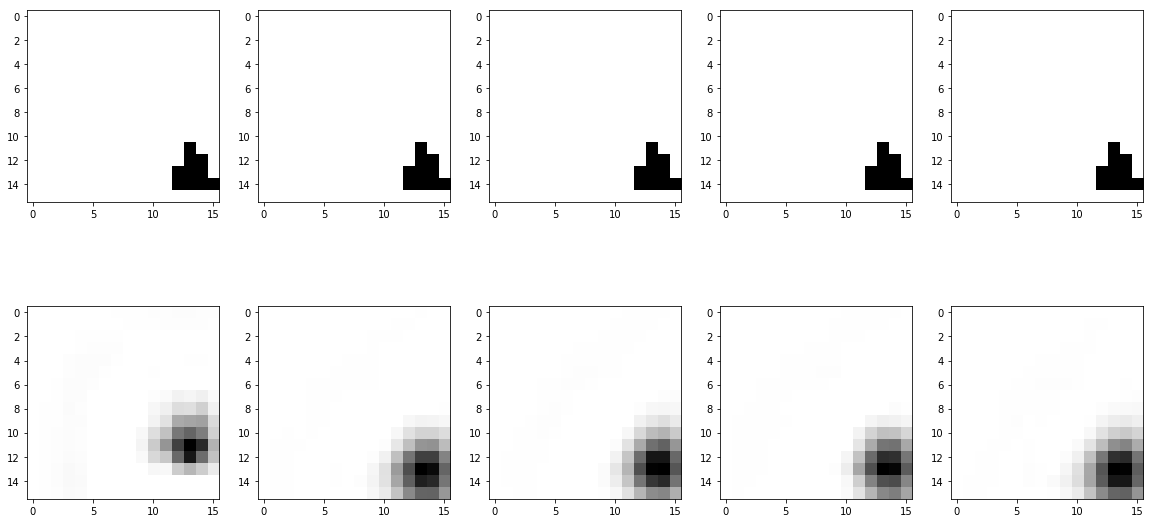

In [455]:
#compare actual to predicted.
data_number =17
fig = plt.figure(figsize=(20,10)) #image sequence from dataset
for i in range(10):
    fig.add_subplot(2,5,i+1)
    if i <= 4:
        plt.imshow(OutputNP[data_number,i].reshape((imgDim,imgDim)),cmap = "Greys")
    else:
        plt.imshow(predictionsNP[data_number,i-5].reshape((imgDim,imgDim)),cmap = "Greys")

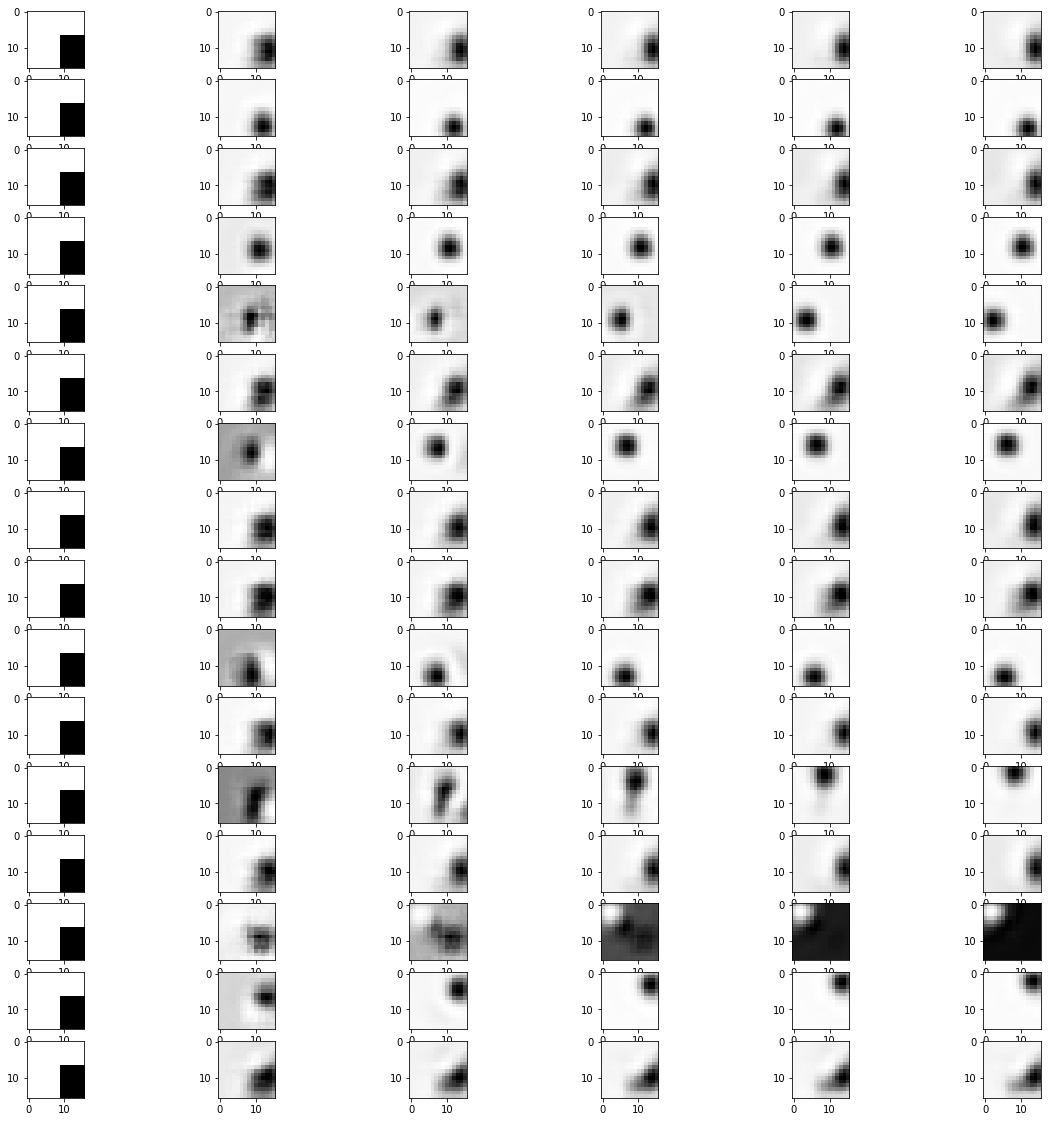

In [456]:
testdata = torch.zeros(numTransforms,6,data.size()[2])
testdata[:,0,:] = data[17,0]
for i in range(numTransforms):
    for j in range(5):
        testdata[i,j+1] = torch.einsum('ij,j -> i', learnedPhi8[:,:,i],testdata[i,j])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],testdataNP.shape[1],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6*numTransforms):
        fig.add_subplot(numTransforms,6,i+1)
        plt.imshow(testdataNP[i//6,i%6],cmap = "Greys")

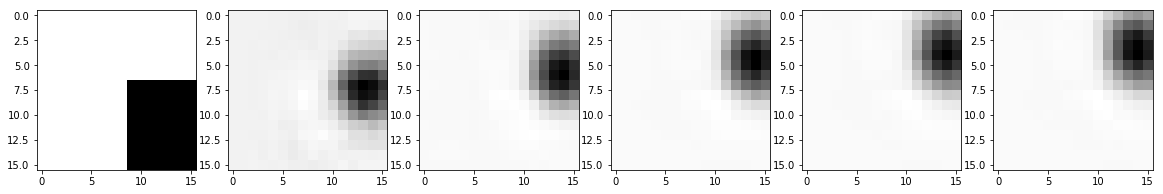

In [450]:
#Action of a single transform on an image. Right frame is action of transform on left frame.
phi_index = 7
testdata = torch.zeros_like(data[17,0:6])
testdata[0] = data[17,0]
for i in range(5):
    testdata[i+1] = torch.einsum('ij,j -> i', learnedPhi5[:,:,phi_index],testdata[i])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6):
        fig.add_subplot(1,6,i+1)
        plt.imshow(testdataNP[i],cmap = "Greys")

In [17]:
# def InferRadius2(localimg, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length):
    
#     for step in range(attStep):
    
#         localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
#         predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
#         error = Output - squash(predictions)
#         dTanh = squash_deriv(predictions)
#         ParDeriv = normalMatrix(movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input2.size()[1]**2)
#         #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
#         dR = torch.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv)
#         radius2 += eta3*dR
                                                                                                                      
                                                                                                                
#     return(radius2)      

# def InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length):
    
#     for step in range(attStep):
    
#         localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
#         predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
#         error = Output - squash(predictions)
#         dTanh = squash_deriv(predictions)
#         centerPD = center_ParDeriv(movie_length, dim, center, radius2, epsilon).view(2,center.size()[2],movie_length, Input2.size()[1]**2)
#         #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
#         dC = torch.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD)
#         center += eta4*dC
                                                                                                                      
                                                                                                                
#     return(center)        

In [21]:
# def InferLocal2(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
#     #now want to infer beta, center, and radii for a single movie sequence
#     #***RADII ARE SQUARED, to make computing the derivative easier***
#     #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
#     dim = int(np.sqrt(movie_seq.size()[1]))
#     Input = movie_seq[:(movie_seq.size()[0]-1)]
#     Output = movie_seq[1:]
#     Input2 = Input.view(Input.size()[0],dim,dim) #just reshape to make region of interest indices more natural
#     movie_length = Input2.size()[0]
    
#     beta = torch.zeros(Input2.size()[0],phi.size()[2]) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
#     center = (dim/2)*torch.ones(2,movie_length,phi.size()[2]).cuda() #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
#     radius2 = ((dim/2)**2)*torch.ones(movie_length,phi.size()[2]).cuda() # shape tk.initialize radius2 at r^2, so start off region of interest as entire image
    
#     for bigStep in range(numInference):
#         beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta2, epsilon, betaStep, movie_length)
#         radius2 = InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length)
#         center = InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length)
#         print(bigStep, end='\r', flush=True)
    
#     finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input.size()[1])
#     final_predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)
#     final_predictionsNP = torch.Tensor.numpy(final_predictions)
    
#     fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
#     for i in range(movie_length):
#         for j in range(2):
#             fig.add_subplot(2,movie_length,movie_length*j+i+1)
#             if j == 0:
#                 plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
#             else: 
#                 plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
#     return((beta,radius2,center))


In [72]:
def localImage(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = torch.zeros(center.size()[2], movie_length, dim,dim).cuda() #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.size()[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = (torch.norm(torch.FloatTensor([i,j]).cuda()-center[:,t,k])**2)/radius2[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix > 1 + epsilon] = 0
    
    LocalInput2 = local_matrix*Input2
    
    return(LocalInput2)

def InferNbd(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim):
    for step in range(attStep):
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        normal_matrix = normalMatrix(movie_length,dim,center,radius2,epsilon)
        distance_pd = torch.zeros((2,center.size()[2], movie_length, dim, dim)).cuda() #shape 2ktdd
    
        for k in range(distance_pd.size()[0]):
            for t in range(movie_length):
                for i in range(dim):
                    for j in range(dim):
                            distance_pd[:,k,t,i,j] = 2*(torch.FloatTensor([i,j]).cuda()-center[:,t,k])

        centerPD = (distance_pd*normal_matrix.unsqueeze(0)).view(2,center.size()[2],movie_length, Input2.size()[1]**2)
        ParDeriv = normal_matrix.view(center.size()[2],movie_length, Input2.size()[1]**2) #radius partial deriv
        
        
        dR = torch.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv)
        radius2 += eta3*dR
        dC = torch.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD)
        center += eta4*dC
    return(radius2,center)

def InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, nbdStep, movie_length, dim):
    
    for step in range(betaStep):
        
        localimg = localImage(Input2, Input2.size()[0], dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input2.size()[1]**2) #calculate localized images and reshape
        
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        dBeta = torch.einsum('ti,ijk, tj, ktj -> tk', error, phi, dTanh, localimg) - sparsePen*sparseDeriv(beta.unsqueeze(1))[0,:,:] - derivPen*timeDeriv(beta.unsqueeze(1))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

def InferLocal(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.size()[1]))
    Input = movie_seq[:(movie_seq.size()[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.view(Input.size()[0],dim,dim) #just reshape to make region of interest indices more natural
    movie_length = Input2.size()[0]
    
    beta = torch.zeros(Input2.size()[0],phi.size()[2]) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*torch.ones(2,movie_length,phi.size()[2]).cuda() #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2)**2)*torch.ones(movie_length,phi.size()[2]).cuda() # shape tk.initialize radius2 at r^2, so start off region of interest as entire image
    
    for bigStep in range(numInf2):
        beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta2, epsilon, betaStep, movie_length, dim)
        radius2, center  = InferNbd(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length,dim)
        print(bigStep, end='\r', flush=True)
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input.size()[1])
    final_predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)
    final_predictionsNP = torch.Tensor.numpy(final_predictions)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))

In [ ]:
testrun = InferLocal(test[0], learnedPhi8, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

In [ ]:
# def InferRadius2NP(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length, dim):
    
#     for step in range(attStep):
    
#         localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
#         predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
#         error = Output - squashNP(predictions)
#         dTanh = squash_derivNP(predictions)
#         ParDeriv = np.multiply(normalMatrixNP(movie_length, dim, center, radius2, epsilon), Input2).reshape((center.shape[2],movie_length, Input2.shape[1]**2))
#         #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
#         dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv, optimize=True)
#         radius2 += eta3*dR
                                                                                                                      
                                                                                                                
#     return(radius2)      

# def InferCenterNP(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length, dim):
    
#     for step in range(attStep):
    
#         localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
#         predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
#         error = Output - squashNP(predictions)
#         dTanh = squash_derivNP(predictions)
#         centerPD = center_ParDeriv(movie_length, dim, center, radius2, epsilon).reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))
#         #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
#         dC = np.einsum('ti, tk, ijk, cktj -> ctk', error, beta, phi, centerPD, optimize=True)
#         center += eta4*dC
                                                                                                                      
                                                                                                                
#     return(center)        

In [730]:
# dim = int(np.sqrt(movie_seq.shape[1]))
# Input = movie_seq[:(movie_seq.shape[0]-1)]
# Output = movie_seq[1:]
# Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
# movie_length = Input2.shape[0]

# beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
# center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
# center = center.astype(float)
# radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
# ratius2 = radius2.astype(float)
# phi = learnedPhi8NP

In [733]:
# def InferLocal2NP(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
#     #now want to infer beta, center, and radii for a single movie sequence
#     #***RADII ARE SQUARED, to make computing the derivative easier***
#     #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
#     dim = int(np.sqrt(movie_seq.shape[1]))
#     Input = movie_seq[:(movie_seq.shape[0]-1)]
#     Output = movie_seq[1:]
#     Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
#     movie_length = Input2.shape[0]
    
#     beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
#     center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
#     radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
#     for bigStep in range(numInference):
#         beta = InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
#         radius2 = InferRadius2NP(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length, dim)
#         center = InferCenterNP(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length, dim)
#         print(bigStep, end='\r')
    
#     finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
#     final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
#     fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
#     for i in range(movie_length):
#         for j in range(2):
#             fig.add_subplot(2,movie_length,movie_length*j+i+1)
#             if j == 0:
#                 plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
#             else: 
#                 plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
#     return((beta,radius2,center))


In [80]:
def norm_densNP(x ,epsilon):
    z = (1/np.sqrt(2*np.pi*epsilon))*np.exp((-(x**2))/(2*epsilon))
    return(z)

def diffMatNP(movie_length, dim, center, radius2):    
    diff_mat = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    diff_mat[:,k,t,i,j] = (np.array([i,j])-center[:,t,k])

                        
    return(diff_mat)

def localImageNP(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = np.linalg.norm(np.array([i,j])-center[:,t,k])/radius2[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix > 1 + epsilon] = 0
    
    LocalInput2 = np.multiply(local_matrix, Input2)
    
    return(LocalInput2)

def InferNbdNP(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim):
    for step in range(attStep):
        localimg = localImageNP(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize = True)
        error = Output - squashNP(predictions)
        dTanh = squash_derivNP(predictions)
        diff = diffMatNP(movie_length, dim, center, radius2)
        dist = np.linalg.norm(diff,axis=0)+.01
        rad_mat = np.ones_like(dist)
        rad_mat = np.multiply(rad_mat,np.expand_dims(np.expand_dims(radius2.T, axis=2), axis = 3)) #array where kt is radius over all ij entries
        PD_1 = norm_densNP(dist, epsilon)
        PD_2 = norm_densNP(dist-rad_mat, epsilon)
        PD_2 = (1/epsilon)*np.multiply(PD_1 - PD_2, diff/dist).reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))                
        centerPD = np.multiply(localimg, PD_2)
        radPD = (1/epsilon)*np.multiply(localimg, PD_1.reshape(center.shape[2],movie_length, Input2.shape[1]**2)) #radius partial deriv
        
        
        dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, radPD, optimize= True)
        radius2 += eta3*dR
        dC = np.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD, optimize = True)
        center += eta4*dC
    return(radius2,center)

def InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim):
    
    for step in range(betaStep):
        
        localimg = localImageNP(Input2, Input2.shape[0], dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
        error = Output - squashNP(predictions)
        dTanh = squash_derivNP(predictions)
        dBeta = np.einsum('ti,ijk, tj, ktj -> tk', error, phi, dTanh, localimg, optimize=True) - sparsePen*sparseDerivNP(np.expand_dims(beta,axis=0))[0,:,:] - derivPen*timeDerivNP(np.expand_dims(beta,axis=0))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

def InferLocalNP(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.shape[1]))
    Input = movie_seq[:(movie_seq.shape[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
    movie_length = Input2.shape[0]
    
    beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
    for bigStep in range(numInference):
        beta1 = InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
        radius2, center = InferNbdNP(Input2, center, Output, radius2, phi, beta1, eta3, eta4, epsilon, attStep, movie_length, dim)
        print(bigStep, end = '\r')
    
    finalImg = localImageNP(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
    final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))


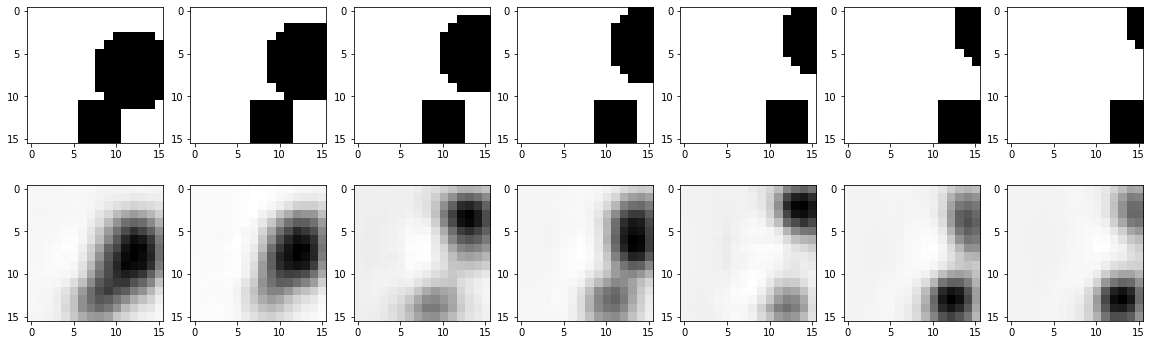

In [91]:
#this run was for 40 total, 20 per center/radius. Learning rates for both were 1000.

testrun2 = InferLocalNP(testNP[19], learnPhi8, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

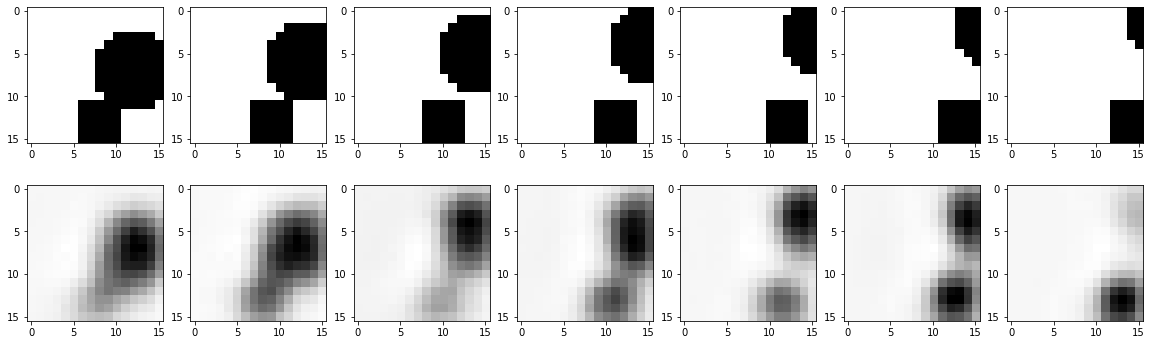

In [81]:
#this run was for 50 total cycles, 20 per center/radius. learning rates for both were 300.

testrun = InferLocalNP(testNP[19], learnPhi8, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

In [122]:
(testrun[2])[0,0,:].shape

(16,)

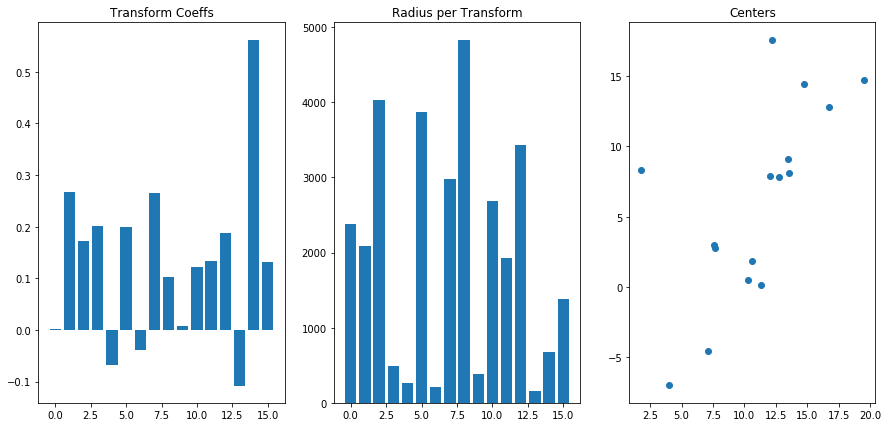

In [126]:
#this run was for 50 total cycles, 20 per center/radius. learning rates for both were 300.

fig_testrun = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun[0])[0,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun[1])[0,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun.add_subplot(1,3,3)
ax3.scatter((testrun[2])[0,0,:],(testrun[2])[1,0,:])
ax3.title.set_text('Centers')

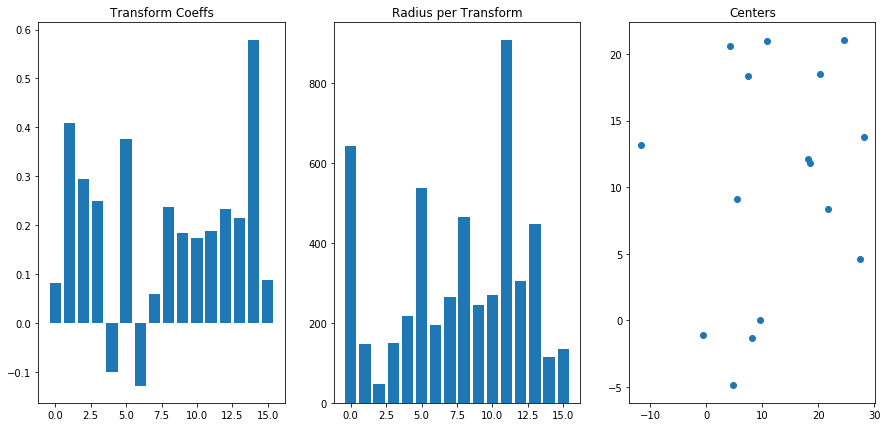

In [127]:
#this run was for 40 total cycles, 20 per center/radius. learning rates for both were 1000.

fig_testrun2 = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun2.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun2[0])[0,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun2.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun2[1])[0,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun2.add_subplot(1,3,3)
ax3.scatter((testrun2[2])[0,0,:],(testrun2[2])[1,0,:])
ax3.title.set_text('Centers')